# All the libraries are imported in following block. Initial load, we have to ensure that the following nltk are downloaded.

# Download necessary NLTK resources (only needed once)
 nltk.download('punkt')       # Standard tokenizer resource
 nltk.download('punkt_tab')   # Additional resource required by some tokenizers
 nltk.download('stopwords')
 nltk.download('wordnet')

In [30]:
# Import necessary libraries and download NLTK resources
import os
import re
import string
import pandas as pd
import numpy as np
import nltk
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import torch

from transformers import pipeline
from textblob import TextBlob
import flair

# Ensure necessary NLTK data is available
# nltk.download('vader_lexicon')

# Download necessary NLTK resources (only needed once)
# nltk.download('punkt')       # Standard tokenizer resource
# nltk.download('punkt_tab')   # Additional resource required by some tokenizers
# nltk.download('stopwords')
# nltk.download('wordnet')

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Scikit-learn imports for vectorization, modeling, and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score

Section B: Data analysis, selection, and labeling

Analyzing the data extracted.

In [13]:
# Load the dataset from Excel
file_path = "../Data/processed/Final_Noon_Datasets.csv"  # Update with actual file path

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV file not found at {csv_file_path}. Please check the path.")

# Load the CSV file into a Pandas DataFrame
try:
    df = pd.read_csv(file_path)
except Exception as e:
    raise Exception(f"Error loading CSV file: {e}")

# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())


First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indicating that ...      1   

           created_utc  is_submitter  contains_no

In [14]:
# Display basic information about the dataset
print("Dataset Overview:\n")
print(df.info())

Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598 entries, 0 to 3597
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   post_id                3598 non-null   object
 1   post_title             3598 non-null   object
 2   comment_id             3598 non-null   object
 3   author                 3360 non-null   object
 4   comment_text           3598 non-null   object
 5   score                  3598 non-null   int64 
 6   created_utc            3598 non-null   object
 7   is_submitter           3598 non-null   bool  
 8   contains_noon_mention  3598 non-null   bool  
 9   type                   3598 non-null   object
 10  subreddit              3079 non-null   object
dtypes: bool(2), int64(1), object(8)
memory usage: 260.1+ KB
None


In [15]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values Per Column:\n")
print(missing_values)


Missing Values Per Column:

post_id                    0
post_title                 0
comment_id                 0
author                   238
comment_text               0
score                      0
created_utc                0
is_submitter               0
contains_noon_mention      0
type                       0
subreddit                519
dtype: int64


In [16]:
# Check for non-null values
non_null_counts = df.notnull().sum()
print("\nNon-null Values Per Column:\n")
print(non_null_counts)




Non-null Values Per Column:

post_id                  3598
post_title               3598
comment_id               3598
author                   3360
comment_text             3598
score                    3598
created_utc              3598
is_submitter             3598
contains_noon_mention    3598
type                     3598
subreddit                3079
dtype: int64


In [17]:
# Check data types
data_types = df.dtypes
print("\nData Types of Each Column:\n")
print(data_types)




Data Types of Each Column:

post_id                  object
post_title               object
comment_id               object
author                   object
comment_text             object
score                     int64
created_utc              object
is_submitter               bool
contains_noon_mention      bool
type                     object
subreddit                object
dtype: object


In [18]:
# Summary statistics for numerical columns
print("\nSummary Statistics for Numerical Columns:\n")
print(df.describe())


Summary Statistics for Numerical Columns:

             score
count  3598.000000
mean      4.115064
std      11.254040
min     -26.000000
25%       1.000000
50%       2.000000
75%       3.000000
max     298.000000


In [19]:
# Summary statistics for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nSummary Statistics for Categorical Columns:\n")
print(df[categorical_columns].describe())
print("\nData Analysis Complete.")



Summary Statistics for Categorical Columns:

       post_id                post_title comment_id         author  \
count     3598                      3598       3598           3360   
unique     821                       805       3598           1986   
top     w16tc7  Lost AED 8,000+ to noon.    m9mjkdv  startuphameed   
freq        63                        63          1             41   

       comment_text          created_utc     type subreddit  
count          3598                 3598     3598      3079  
unique         3572                 3598        1         9  
top            Noon  2025-01-28 16:33:14  comment     dubai  
freq             12                    1     3598      2012  

Data Analysis Complete.


# Section B: Data analysis, selection, and labeling

## Adding Vader Lexicon, Flair and TextBlob sentiment score to get the exact value of the sentiment.

### There are three columns added to rate the positive, negative or neutral sentiments. 
### Sentiment_VADER, Sentiment_TextBlob & Sentiment_Flair


## Adding final column on a consolidated sentiment rating which is a 5 pointer based system as mentioned below.
	•	5 → All three sentiments are Positive
	•	4 → Two sentiments are Positive
	•	3 → All three are Neutral or two are Neutral
	•	2 → Two sentiments are Negative
	•	1 → All three sentiments are Negative

In [24]:

# Initialize Sentiment Analyzers
vader_analyzer = SentimentIntensityAnalyzer()
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
classifier = pipeline("sentiment-analysis")
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
longformer_classifier = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Customizing VADER's lexicon
new_words = {
    "falsely advertised": -3.0,
    "overheating": -3.0,
    "returned": -2.0,
    "refunds": -1.5,
    "fortunate": 0.5
}
vader_analyzer.lexicon.update(new_words)

# Function to get sentiment using VADER with enhanced lexicon
def get_vader_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

# Function to get sentiment using TextBlob
def get_textblob_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

# Function to get sentiment using Flair
def get_flair_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)
    sentiment = sentence.labels[0].value
    return "Positive" if sentiment == 'POSITIVE' else "Negative" if sentiment == 'NEGATIVE' else "Neutral"

def get_roberta_sentiment(text, max_length=512, overlap=128):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = roberta_classifier(chunk)[0]
        if result['label'] == 'LABEL_2':  # Positive sentiment
            sentiment_scores["Positive"] += 1
        elif result['label'] == 'LABEL_0':  # Negative sentiment
            sentiment_scores["Negative"] += 1
        else:  # Neutral sentiment
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Function to apply Longformer with a sliding window (handles text > 512 tokens)
def get_longformer_sentiment(text, max_length=4096, overlap=512):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = longformer_classifier(chunk)[0]  # Get model output

        # Retrieve model-generated label dynamically
        label = result['label']

        if "pos" in label.lower():  # Matches positive sentiment labels
            sentiment_scores["Positive"] += 1
        elif "neg" in label.lower():  # Matches negative sentiment labels
            sentiment_scores["Negative"] += 1
        else:  # Assume any other label is neutral
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Rule-based sentiment adjustment
def get_adjusted_sentiment(text):
    negative_keywords = ["falsely advertised", "overheating", "returned", "refund", "issue"]
    positive_keywords = ["fortunately", "buy a new one"]
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    if neg_count > pos_count:
        return "Negative"
    elif pos_count > neg_count:
        return "Positive"
    else:
        return "Neutral"

print("\nStarted the sentiment analysis\n")

# Apply sentiment analysis to the comment_text column
df['Sentiment_VADER'] = df['comment_text'].apply(get_vader_sentiment)
df['Sentiment_TextBlob'] = df['comment_text'].apply(get_textblob_sentiment)
df['Sentiment_Flair'] = df['comment_text'].apply(get_flair_sentiment)
df['Sentiment_RoBERTa'] = df['comment_text'].apply(get_roberta_sentiment)
df['Sentiment_Longformer'] = df['comment_text'].apply(get_longformer_sentiment)
df['Sentiment_Adjusted'] = df['comment_text'].apply(get_adjusted_sentiment)

# Function to calculate the final 5-point rating
def calculate_rating(row):
    sentiments = [
        row['Sentiment_VADER'],
        row['Sentiment_TextBlob'],
        row['Sentiment_Flair'],
        row['Sentiment_RoBERTa'],
        row['Sentiment_Longformer'],
        row['Sentiment_Adjusted']
    ]
    positive_count = sentiments.count("Positive")
    negative_count = sentiments.count("Negative")
    if positive_count >= 4:
        return 5
    elif positive_count == 3:
        return 4
    elif negative_count == 3:
        return 2
    elif negative_count >= 4:
        return 1
    else:
        return 3

# Apply the rating calculation
df['Sentiment_Rating'] = df.apply(calculate_rating, axis=1)

print(f"Sentiment analysis complete. Results saved")

# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())


Started the sentiment analysis

Sentiment analysis complete. Results saved

First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indi


Sentiment Rating Distribution:
Sentiment_Rating
1     526
2     543
3    1657
4     499
5     373
Name: count, dtype: int64


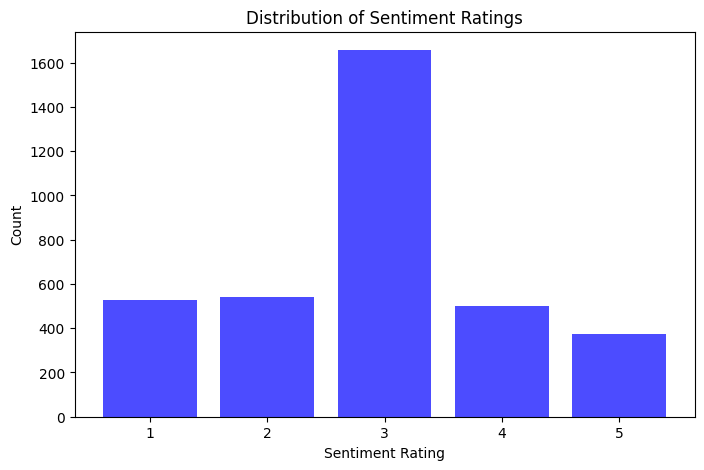


Most Common Words in Comments with Rating 5:
[('.', 961), ('the', 549), (',', 508), ('and', 457), ('I', 454), ('a', 311), ('to', 295), ('noon', 292), ('is', 281), ('it', 273)]

Most Common Words in Comments with Rating 4:
[('.', 1367), ('the', 787), (',', 709), ('and', 628), ('I', 586), ('to', 529), ('noon', 430), ('a', 416), ('it', 394), ('is', 370)]

Most Common Words in Comments with Rating 3:
[('.', 2898), ('the', 1777), (',', 1488), ('noon', 1174), ('and', 1140), ('I', 1137), ('to', 1103), ('a', 1003), ('it', 915), ('is', 810)]

Most Common Words in Comments with Rating 2:
[('.', 1481), ('the', 976), (',', 788), ('I', 665), ('and', 640), ('to', 629), ('a', 617), ('noon', 458), ('it', 455), ('is', 388)]

Most Common Words in Comments with Rating 1:
[('.', 1470), ('the', 928), ('and', 736), ('I', 734), (',', 697), ('to', 679), ('a', 627), ('it', 464), ('is', 397), ('noon', 396)]


In [27]:
# Analysis of Sentiment Ratings
rating_counts = df['Sentiment_Rating'].value_counts().sort_index()
print("\nSentiment Rating Distribution:")
print(rating_counts)

# Plot sentiment rating distribution
plt.figure(figsize=(8,5))
plt.bar(rating_counts.index, rating_counts.values, color='blue', alpha=0.7)
plt.xlabel("Sentiment Rating")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Ratings")
plt.show()

# Further Text Analytics on Ratings
for rating in [5, 4, 3, 2, 1]:
    print(f"\nMost Common Words in Comments with Rating {rating}:")
    rating_text = " ".join(df[df['Sentiment_Rating'] == rating]['comment_text'].dropna())
    words = nltk.FreqDist(nltk.word_tokenize(rating_text))
    print(words.most_common(10))

In [28]:
# Save the results to an Excel file
output_path = "Final_Noon_Datasets_with_Sentiments.xlsx"
df.to_excel(output_path, index=False)

# Preprocessing Noon Company Reviews (Extracted from Reddit)

Preprocessing is a critical step in Natural Language Processing (NLP) tasks, especially for sentiment analysis. Raw reviews from social media platforms like Reddit contain noise, irrelevant words, and inconsistencies that can reduce the accuracy of sentiment classification.

## Why is Preprocessing Important?
- Reddit comments contain informal language (slang, emojis, abbreviations, etc.)
- Reviews may have unnecessary elements (punctuation, special characters, URLs)
- Noisy text reduces sentiment model performance
- Proper normalization ensures better consistency across comments

## Steps in Preprocessing Reddit Reviews on Noon

### 1. Letter Casing (Convert all text to lowercase)
- Reviews may contain mixed case text (e.g., "Great service" vs "GREAT SERVICE")
- Converting all text to lowercase ensures uniformity.

### 2. Tokenization (Breaking text into words/tokens)
- Example review:
  ```
  "Noon’s service was great! I loved it."
  ```
  Becomes:
  ```
  ['noon', 'service', 'was', 'great', 'i', 'loved', 'it']
  ```
- Tokenization allows word-level analysis.

### 3. Noise Removal (Eliminating unwanted characters)
- Remove:
  - HTML tags
  - Punctuation (?, !, ...)
  - Special characters (@, #, $)
  - Extra whitespace
  - URLs (https://noon.com)

### 4. Stopword Removal (Eliminating non-informative words)
- Words like "is", "the", "and", "it" do not impact sentiment.
- Removing stopwords reduces noise and focuses on meaningful words.
- Example:
  ```
  "The customer support was really bad."
  ```
  Transforms to:
  ```
  "customer support bad"
  ```

### 5. Normalization (Converting words to a standard format)
- Fix inconsistencies in text:
  - "gr8" → "great"
  - "u" → "you"
  - "iPhone 15 pro" → "iphone 15 pro"
- Convert informal text to proper English.

### 6. Stemming & Lemmatization (Reducing words to root form)
- **Stemming** removes suffixes, but may distort words:
  - "returning" → "return"
  - "customers" → "custom"
- **Lemmatization** provides a more accurate base form:
  - "better" → "good"
  - "worse" → "bad"
  - "running" → "run"

For Noon’s reviews, **lemmatization is preferred** to retain the original meaning.

---

In [32]:
# Function to convert text to lowercase
def to_lowercase(text):
    return text.lower()

def remove_html_tags(text):
    if "<" in text and ">" in text:  
        return BeautifulSoup(text, "html.parser").get_text()
    return text  

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)  # Remove links

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove special characters
def remove_special_chars(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Function to tokenize text
def tokenize(text):
    return word_tokenize(text)

# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Function to convert emojis to text
def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

# Function to perform lemmatization
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = to_lowercase(text)
    text = remove_html(text)
    text = remove_urls(text)
    text = convert_emojis(text)
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    return " ".join(tokens)

# Apply preprocessing to the comment_text column
df['processed_comment'] = df['comment_text'].apply(preprocess_text)

# Save the preprocessed data
output_path = "Final_Noon_Datasets_Preprocessed.xlsx"
df.to_excel(output_path, index=False)

print(f"Preprocessing complete. Results saved to {output_path}")

# Display first few rows of preprocessed data
print(df[['comment_text', 'processed_comment']].head())


/var/folders/gx/9cn8k5x52gq_wpn2s2w4j2340000gn/T/ipykernel_22986/1077419593.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
/var/folders/gx/9cn8k5x52gq_wpn2s2w4j2340000gn/T/ipykernel_22986/1077419593.py:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


Preprocessing complete. Results saved to Final_Noon_Datasets_Preprocessed.xlsx
                                        comment_text  \
0                          will reach border by noon   
1  Be careful of blowing dust during late morning...   
2  Apart from boring things, you can managed. How...   
3  You are looking at a tag in noon app saying 1 ...   
4  Are you sure? There's nothing indicating that ...   

                                   processed_comment  
0                                  reach border noon  
1  careful blowing dust late morning noon sand he...  
2  apart boring thing managed however light pole ...  
3  looking tag noon app saying 1 year warranty sa...  
4  sure there nothing indicating reading noon war...  


In [33]:
# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())


First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indicating that ...      1   

           created_utc  is_submitter  contains_no

In [34]:

# Initialize Sentiment Analyzers
vader_analyzer = SentimentIntensityAnalyzer()
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
classifier = pipeline("sentiment-analysis")
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
longformer_classifier = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Customizing VADER's lexicon
new_words = {
    "falsely advertised": -3.0,
    "overheating": -3.0,
    "returned": -2.0,
    "refunds": -1.5,
    "fortunate": 0.5
}
vader_analyzer.lexicon.update(new_words)

# Function to get sentiment using VADER with enhanced lexicon
def get_vader_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

# Function to get sentiment using TextBlob
def get_textblob_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

# Function to get sentiment using Flair
def get_flair_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)
    sentiment = sentence.labels[0].value
    return "Positive" if sentiment == 'POSITIVE' else "Negative" if sentiment == 'NEGATIVE' else "Neutral"

def get_roberta_sentiment(text, max_length=512, overlap=128):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = roberta_classifier(chunk)[0]
        if result['label'] == 'LABEL_2':  # Positive sentiment
            sentiment_scores["Positive"] += 1
        elif result['label'] == 'LABEL_0':  # Negative sentiment
            sentiment_scores["Negative"] += 1
        else:  # Neutral sentiment
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Function to apply Longformer with a sliding window (handles text > 512 tokens)
def get_longformer_sentiment(text, max_length=4096, overlap=512):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = longformer_classifier(chunk)[0]  # Get model output

        # Retrieve model-generated label dynamically
        label = result['label']

        if "pos" in label.lower():  # Matches positive sentiment labels
            sentiment_scores["Positive"] += 1
        elif "neg" in label.lower():  # Matches negative sentiment labels
            sentiment_scores["Negative"] += 1
        else:  # Assume any other label is neutral
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Rule-based sentiment adjustment
def get_adjusted_sentiment(text):
    negative_keywords = ["falsely advertised", "overheating", "returned", "refund", "issue"]
    positive_keywords = ["fortunately", "buy a new one"]
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    if neg_count > pos_count:
        return "Negative"
    elif pos_count > neg_count:
        return "Positive"
    else:
        return "Neutral"

print("\nStarted the sentiment analysis\n")

# Apply sentiment analysis to the comment_text column
df['Sentiment_VADER'] = df['comment_text'].apply(get_vader_sentiment)
df['Sentiment_TextBlob'] = df['comment_text'].apply(get_textblob_sentiment)
df['Sentiment_Flair'] = df['comment_text'].apply(get_flair_sentiment)
df['Sentiment_RoBERTa'] = df['comment_text'].apply(get_roberta_sentiment)
df['Sentiment_Longformer'] = df['comment_text'].apply(get_longformer_sentiment)
df['Sentiment_Adjusted'] = df['comment_text'].apply(get_adjusted_sentiment)

# Function to calculate the final 5-point rating
def calculate_rating(row):
    sentiments = [
        row['Sentiment_VADER'],
        row['Sentiment_TextBlob'],
        row['Sentiment_Flair'],
        row['Sentiment_RoBERTa'],
        row['Sentiment_Longformer'],
        row['Sentiment_Adjusted']
    ]
    positive_count = sentiments.count("Positive")
    negative_count = sentiments.count("Negative")
    if positive_count >= 4:
        return 5
    elif positive_count == 3:
        return 4
    elif negative_count == 3:
        return 2
    elif negative_count >= 4:
        return 1
    else:
        return 3

# Apply the rating calculation
df['Sentiment_Rating'] = df.apply(calculate_rating, axis=1)

print(f"Sentiment analysis complete. Results saved")

# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

Started the sentiment analysis

Sentiment analysis complete. Results saved

First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed.